In [322]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from scipy.stats import chisquare, chi2_contingency
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('UCI_Credit_Card.csv')

In [8]:
data.drop_duplicates(inplace=True)

# Feature Engineering

In [10]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

We will split the features to demographics, pay_status, billing, payment amount and the y itself to be able to make a more comprehensive feature engineering.

In [11]:
data['ID'].nunique()

30000

In [12]:
data.set_index('ID', inplace=True)

In [90]:
y = data['default.payment.next.month']
demog = data[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
payment_amt = data[[k for k in data if k.startswith('PAY_AMT')]]
bill_data = data[[k for k in data if k.startswith('BILL')]]
pay_status = data[[k for k in data if k not in (list(demog) + list(payment_amt) + list(bill_data) + ['default.payment.next.month'])]]

In [91]:
data.shape[1], payment_amt.shape[1], bill_data.shape[1], pay_status.shape[1], demog.shape[1]

(24, 6, 6, 6, 5)

### Demography

For demography, we are not doing any feature engineering yet

In [92]:
demog.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
ID,,,,,
1,20000.0,2,2,1,24
2,120000.0,2,2,2,26
3,90000.0,2,2,2,34
4,50000.0,2,2,1,37
5,50000.0,1,2,1,57


### Payment Status

In [93]:
pay_status.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,
1,2,2,-1,-1,-2,-2
2,-1,2,0,0,0,2
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,-1,0,-1,0,0,0


Based on the information provided, payment status is a nominal/categorical data. We will then treat them accordingly.<br>
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)<br>
PAY_2: Repayment status in August, 2005 (scale same as above)<br>
PAY_3: Repayment status in July, 2005 (scale same as above)<br>
PAY_4: Repayment status in June, 2005 (scale same as above)<br>
PAY_5: Repayment status in May, 2005 (scale same as above)<br>
PAY_6: Repayment status in April, 2005 (scale same as above)

Additionally from https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/71771#423791 , scale -2 and 0 means the customer owes nothing to the bank, hence payment is not needed.

In [94]:
pay_status[pay_status['PAY_0']==8]

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,
650,8,7,6,5,4,3
750,8,7,6,5,4,3
832,8,7,6,5,4,3
982,8,7,6,5,4,3
2363,8,7,6,5,4,3
2917,8,7,6,5,4,3
4337,8,7,6,5,4,3
4388,8,7,6,5,4,3
4445,8,7,6,5,4,3


In a short glance, the data seems to be valid, whereas the number decreases. No occurence that 2 columns have same number (which will be a data error if it occured)

In [95]:
pay_status.describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


to avoid data misinterpretation, -2 will be replaced with zero in accordance to the description above.

In [96]:
pay_status.replace(-2, 0, inplace=True)

C:\Users\sintyadi.thong\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Our first feature engineering will be to see the longest, shortest, average, and most frequent repayment status of each customer.

In [97]:
for funcs in [['minimum','min(axis=1)'], ['maximum', 'max(axis=1)'], ['average', 'mean(axis=1)'], ['most_frequent', 'mode(axis=1)[0]']]:
    print(funcs)
    pay_status[funcs[0]] = eval('pay_status.'+(funcs[1]))
    

['minimum', 'min(axis=1)']
['maximum', 'max(axis=1)']
['average', 'mean(axis=1)']
['most_frequent', 'mode(axis=1)[0]']


C:\Users\sintyadi.thong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
isY = lambda x:int(x=='Y')
countRiskFactors = lambda row: int(row["PAY_0"]>0) +int(row["PAY_2"]>0) + int(row["PAY_3"]>0) + int(row["PAY_4"]>0) + int(row["PAY_5"]>0) + int(row["PAY_6"]>0)

pay_status['number_of_delq'] = pay_status.apply(countRiskFactors,axis=1)


C:\Users\sintyadi.thong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [100]:
pay_status.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,minimum,maximum,average,most_frequent,number_of_delq
ID,,,,,,,,,,,
1,2,2,-1,-1,0,0,-1,2,0.375,-1.0,2
2,-1,2,0,0,0,2,-1,2,0.500,0.0,2
3,0,0,0,0,0,0,0,0,0.000,0.0,0
4,0,0,0,0,0,0,0,0,0.000,0.0,0
5,-1,0,-1,0,0,0,-1,0,-0.375,0.0,0


### Billing Amount

In [102]:
bill_data.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
ID,,,,,,
1,3913.0,3102.0,689.0,0.0,0.0,0.0
2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0
3,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0
4,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0
5,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0


For billing data, we will be working on several iterations, including the utilization ratio, the remaining limit ratio, growth ratio.

In [109]:
import gc
gc.collect()

20

In [195]:
bill_data_util = bill_data.divide(demog['LIMIT_BAL'], axis=0)
bill_data_util= bill_data_util.add_prefix('UTIL_')
bill_data_remaining = bill_data.subtract(demog['LIMIT_BAL'], axis=0)*-1
bill_data_remaining= bill_data_remaining.add_prefix('REMAIN_')

In [196]:
def growth_all(data, time_frame):
    k = pd.DataFrame()
    time_frame -= 1
    get = list(data)
    for i in range(time_frame):
        name = data.columns[0][:-1]+'_grwth_'+str(i+1)+str(i+2)
        
        k[name] = data[get[i]]/data[get[i+1]]
        k[name].fillna(0, inplace=True)
    l = pd.DataFrame()
    for funcs in [['min','min(axis=1)'], ['max', 'max(axis=1)'], ['avg', 'mean(axis=1)'], ['mst_frq', 'mode(axis=1)[0]']]:
        name = data.columns[0][:-1]+"_"+funcs[0]+"_{}_mth_grwth".format(time_frame+1)
        l[name] = eval('k.'+(funcs[1]))
    return k, l

def growth_between(data, time_frame):
    k = pd.DataFrame()
    time_frame -=1
    get = list(data)
    name = data.columns[0][:-1]+"_{}_mth_grwth".format(time_frame)
    k[name] = data[get[0]] / data[get[time_frame]]
    k[name].fillna(0, inplace=True)
    return k
    

Using the function above, we will feature engineer the billing amount data including its variant (utilization and remaining). Multicolinearity might appear, but we will take care of that in later stage.

In [199]:
# Bill Amount data
bill_amt_full = pd.DataFrame()
remaining_amt_full = pd.DataFrame()
util_full = pd.DataFrame()
bill = dict()
for k in [[bill_amt_full, bill_data, 'bill_result'], [remaining_amt_full, bill_data_remaining, 'remaining_result'], [util_full, bill_data_util, 'util_result']]:
    k[0] = pd.concat([k[0], k[1]], axis=1)
    print(k[0].shape)
    for time in [3,6]:
        a, b = growth_all(k[1], time)
        c = growth_between(k[1], time)
        print(k[0].shape)
        k[0] = pd.concat([k[0], a], axis=1)
        k[0] = pd.concat([k[0], b], axis=1)
        k[0] = pd.concat([k[0], c], axis=1)
        bill[k[2]] = k[0].copy()

        

(30000, 6)
(30000, 6)
(30000, 13)
(30000, 6)
(30000, 6)
(30000, 13)
(30000, 6)
(30000, 6)
(30000, 13)


In [205]:
billing_merge = pd.concat(bill.values(), axis=1)

In [209]:
del bill
gc.collect()

NameError: name 'bill' is not defined

In [210]:
billing_merge

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,BILL_AMT_grwth_12,BILL_AMT_grwth_23,BILL_AMT_min_3_mth_grwth,BILL_AMT_max_3_mth_grwth,...,UTIL_BILL_AMT_grwth_12,UTIL_BILL_AMT_grwth_23,UTIL_BILL_AMT_grwth_34,UTIL_BILL_AMT_grwth_45,UTIL_BILL_AMT_grwth_56,UTIL_BILL_AMT_min_6_mth_grwth,UTIL_BILL_AMT_max_6_mth_grwth,UTIL_BILL_AMT_avg_6_mth_grwth,UTIL_BILL_AMT_mst_frq_6_mth_grwth,UTIL_BILL_AMT_5_mth_grwth
ID,,,,,,,,,,,,,,,,,,,,,
1,3913.0,3102.0,689.0,0.0,0.0,0.0,1.261444,4.502177,1.261444,4.502177,...,1.261444,4.502177,inf,0.000000,0.000000,0.000000,inf,inf,0.000000,inf
2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,1.554783,0.643177,0.643177,1.554783,...,1.554783,0.643177,0.819682,0.947033,1.059491,0.643177,1.554783,1.004833,0.643177,0.822447
3,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,2.084480,1.034516,1.034516,2.084480,...,2.084480,1.034516,0.946131,0.958724,0.961348,0.946131,2.084480,1.197040,0.946131,1.880442
4,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,0.974229,0.978536,0.974229,0.978536,...,0.974229,0.978536,1.740870,0.977727,0.980100,0.974229,1.740870,1.130292,0.974229,1.590348
5,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,1.519753,0.158225,0.158225,1.519753,...,1.519753,0.158225,1.711318,1.093701,1.000784,0.158225,1.711318,1.096756,0.158225,0.450421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,0.979945,0.925371,0.925371,0.979945,...,0.979945,0.925371,2.367676,2.817300,1.954756,0.925371,2.817300,1.809010,0.925371,11.824030
29997,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,0.920678,0.521987,0.521987,0.920678,...,0.920678,0.521987,0.390021,1.730058,inf,0.390021,inf,inf,0.390021,inf
29998,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,1.062277,1.216824,1.062277,1.216824,...,1.062277,1.216824,0.132101,1.014381,1.063285,0.132101,1.216824,0.897773,0.132101,0.184171


### Payment Amount

The feature engineering of payment will follow the same feature engineering steps given in the billing. But additional feature will be given: ratio between payment and billing as well as remaining billing after payment

In [214]:
payment_amt.head()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,
1,0.0,689.0,0.0,0.0,0.0,0.0
2,0.0,1000.0,1000.0,1000.0,0.0,2000.0
3,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
4,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
5,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [237]:
bdata = bill_data.copy()
bdata.columns = list(payment_amt)
pay_to_limit = payment_amt.div(demog['LIMIT_BAL'], axis=0)
pay_to_limit = pay_to_limit.add_prefix('LMT_TO_')
remaining_bill = payment_amt.subtract(bdata, axis=1) * -1
remaining_bill = remaining_bill.add_prefix('RMAIN_AFTR_')
pay_to_bill = payment_amt.div(bdata, axis=1)
pay_to_bill = pay_to_bill.add_prefix('BILL_TO_')
del bdata
gc.collect()

84

In [238]:
# Bill Amount data
payment_amt_full = pd.DataFrame()
remaining_bill_full = pd.DataFrame()
pay_to_limit_full = pd.DataFrame()
pay_to_bill_full = pd.DataFrame()
pay = dict()
for k in [[payment_amt_full, payment_amt, 'payment_result'], [remaining_bill_full, remaining_bill, 'remaining_bill_result'], [pay_to_limit_full, pay_to_limit, 'pay_to_limit_result'], [pay_to_bill_full, pay_to_bill, 'pay_to_bill_result']]:
    k[0] = pd.concat([k[0], k[1]], axis=1)
    print(k[0].shape)
    for time in [3,6]:
        a, b = growth_all(k[1], time)
        c = growth_between(k[1], time)
        print(k[0].shape)
        k[0] = pd.concat([k[0], a], axis=1)
        k[0] = pd.concat([k[0], b], axis=1)
        k[0] = pd.concat([k[0], c], axis=1)
        pay[k[2]] = k[0].copy()

        

(30000, 6)
(30000, 6)
(30000, 13)
(30000, 6)
(30000, 6)
(30000, 13)
(30000, 6)
(30000, 6)
(30000, 13)
(30000, 6)
(30000, 6)
(30000, 13)


In [239]:
pay_merge = pd.concat(pay.values(), axis=1)
del pay
gc.collect()

20

### Concat all the features

In [280]:
x = pd.concat([demog, pay_status, billing_merge, pay_merge], axis=1)

In [281]:
x.shape

(30000, 177)

In [282]:
# remove possibly duplicate columns due to feature engineering
x = x.loc[:,~x.columns.duplicated()]
x.shape

(30000, 163)

# Multicolinearity filter

In [283]:
categories = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


In [284]:
xcat = x[categories]
xnum = x.drop(categories, axis=1)

As infinite values in the dataset, we should  handle them as we go through the process.

### Replace infinites with maximum values

In [285]:
for col in list(xnum):
    if np.max(xnum[col])==np.inf:
        m = xnum.loc[xnum[col] != np.inf, col].max()
        xnum[col].replace(np.inf,m,inplace=True)
    else:
        None

    if np.min(xnum[col])==-np.inf:
        m = xnum.loc[xnum[col] != -np.inf, col].min()
        xnum[col].replace(-np.inf,m,inplace=True)
    else:
        None

### Multicolinearity via pearson for numeric data

In [286]:

ze = xnum.corr()
columnss = np.full((ze.shape[0],), True, dtype=bool)
for i in range(ze.shape[0]):
    for j in range(i+1, ze.shape[0]):
        if ze.iloc[i,j] >=0.8 or ze.iloc[i,j] <=-0.8:
            if columnss[j]:
                columnss[j] = False

s = ze.head(1)
selected_columns = s.columns[columnss]
t = list(s[selected_columns])
             

xnum_clean = xnum[t]


In [287]:
#here are the unexpectedly multicol columns
set(list(xnum)) - set(list(xnum_clean))

{'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'BILL_AMT_avg_3_mth_grwth',
 'BILL_AMT_mst_frq_3_mth_grwth',
 'BILL_TO_PAY_AMT_avg_3_mth_grwth',
 'BILL_TO_PAY_AMT_avg_6_mth_grwth',
 'BILL_TO_PAY_AMT_grwth_34',
 'BILL_TO_PAY_AMT_grwth_56',
 'BILL_TO_PAY_AMT_max_3_mth_grwth',
 'BILL_TO_PAY_AMT_max_6_mth_grwth',
 'BILL_TO_PAY_AMT_mst_frq_3_mth_grwth',
 'LMT_TO_PAY_AMT_2_mth_grwth',
 'LMT_TO_PAY_AMT_5_mth_grwth',
 'LMT_TO_PAY_AMT_avg_3_mth_grwth',
 'LMT_TO_PAY_AMT_avg_6_mth_grwth',
 'LMT_TO_PAY_AMT_grwth_12',
 'LMT_TO_PAY_AMT_grwth_23',
 'LMT_TO_PAY_AMT_grwth_34',
 'LMT_TO_PAY_AMT_grwth_45',
 'LMT_TO_PAY_AMT_grwth_56',
 'LMT_TO_PAY_AMT_max_3_mth_grwth',
 'LMT_TO_PAY_AMT_max_6_mth_grwth',
 'LMT_TO_PAY_AMT_min_3_mth_grwth',
 'LMT_TO_PAY_AMT_min_6_mth_grwth',
 'LMT_TO_PAY_AMT_mst_frq_3_mth_grwth',
 'LMT_TO_PAY_AMT_mst_frq_6_mth_grwth',
 'PAY_AMT_avg_3_mth_grwth',
 'PAY_AMT_avg_6_mth_grwth',
 'PAY_AMT_mst_frq_3_mth_grwth',
 'REMAIN_BILL_AMT1',
 'REMAIN_BILL_AMT2',
 'REMA

In [288]:
xnum_clean.shape

(30000, 80)

In [292]:

d = defaultdict(LabelEncoder)
fit = xcat.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
xcat_encoded = xcat.apply(lambda x: d[x.name].transform(x))

In [295]:
from scipy.stats import chisquare, chi2_contingency
drop_cols = []
for j in range(len(categories)-1):
    for k in range(j+1, len(categories)):

        pvalue = chi2_contingency(pd.crosstab(xcat_encoded[categories[j]],xcat_encoded[categories[k]]))[1]
        if pvalue < 0.05:
            drop_cols.append(categories[k])
            print('{} shall be dropped with pvalue of {} against {}'.format(categories[k],  pvalue,  categories[j]))
        else:
            None
        


EDUCATION shall be dropped with pvalue of 2.765464336611277e-05 against SEX
MARRIAGE shall be dropped with pvalue of 3.2049390980663363e-07 against SEX
PAY_0 shall be dropped with pvalue of 1.4625915624070017e-08 against SEX
PAY_2 shall be dropped with pvalue of 3.899168320345592e-14 against SEX
PAY_3 shall be dropped with pvalue of 1.2571413679257262e-12 against SEX
PAY_4 shall be dropped with pvalue of 3.7764536451057735e-13 against SEX
PAY_5 shall be dropped with pvalue of 5.513001897503634e-11 against SEX
PAY_6 shall be dropped with pvalue of 6.655840653803592e-09 against SEX
MARRIAGE shall be dropped with pvalue of 5.0143091094744556e-241 against EDUCATION
PAY_0 shall be dropped with pvalue of 5.1048089185695523e-129 against EDUCATION
PAY_2 shall be dropped with pvalue of 8.257159817308712e-137 against EDUCATION
PAY_3 shall be dropped with pvalue of 1.6232627725763314e-114 against EDUCATION
PAY_4 shall be dropped with pvalue of 4.1840201795602027e-88 against EDUCATION
PAY_5 shall 

In [296]:
for cols in np.unique(drop_cols):
    xcat_encoded.drop(columns=cols, inplace=True)

In [297]:
xcat_encoded

,SEX
ID,
1,1
2,1
3,1
4,1
5,0
...,...
29996,0
29997,0
29998,0


# Train Test Split

In [303]:
## Concat xcat and xnum
x = pd.concat([xnum_clean, xcat_encoded], axis=1)

In [304]:
y.value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [305]:
x.isnull().any().sum()

7

There are some nulls in the x, which we will need to imput at later stages, but as we have seen that the categorical data contains no null in previous steps, we will handle the nulls with numerical imputation methods. THe categories will not be affected due to the cleanness of the data.

In [306]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [307]:
imput = SimpleImputer(strategy='median')
imput.fit(x_train)
x_train_imp = pd.DataFrame(imput.transform(x_train), columns=x_train.columns, index = x_train.index)
x_test_imp = pd.DataFrame(imput.transform(x_test), columns=x_test.columns, index = x_test.index)

In [308]:
x_train_imp.isnull().any().sum()

0

Due to data imbalance, we will do some oversampling and undersampling methods, and finally will choose the best algorithm and sampling methods.

In [309]:
sm = SMOTE(random_state=108)
tl = TomekLinks()
x_train_ov, y_train_ov = sm.fit_resample(x_train_imp, y_train)
x_train_un, y_train_un = tl.fit_resample(x_train_imp, y_train)

In [310]:
dt = DecisionTreeClassifier(random_state=108)
rf = RandomForestClassifier(random_state=108)
gb = GradientBoostingClassifier(random_state=108)
dt_param = {'criterion':('gini', 'entropy'), 'max_depth':[1, 3, 5, 10], 'min_samples_split':[2,4,8,16], 'min_samples_leaf':[1,2,4,6,8,10]}


n_estimators = [10, 25, 50, 100]
max_features = ['auto', 'sqrt']
max_depth = [3, 5, 10, 12, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

rf_param = {'n_estimators': n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
gb_param = {'learning_rate':learning_rates, 'n_estimators': n_estimators, 'max_depth':max_depth, 'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf, 'max_features':max_features}

In [313]:

name = []
k = []
tr_auc = []
te_auc = []
method = []
trans = dict()
for data_used in [[x_train_ov, y_train_ov, 'oversampling'], [x_train_un, y_train_un, 'undersampling']]:
    x_use = data_used[0]
    y_use = data_used[1]
    gdt = RandomizedSearchCV(dt, dt_param, n_jobs=-1, scoring='roc_auc', n_iter=15, random_state=108)
    grf = RandomizedSearchCV(rf, rf_param, n_jobs=-1, scoring='roc_auc', n_iter=15, random_state=108)
    ggb = RandomizedSearchCV(gb, gb_param, n_jobs=-1, scoring='roc_auc', n_iter=15, random_state=108)
    new_dt = DecisionTreeClassifier(**gdt.fit(x_use, y_use).best_params_, random_state=108)
    
    new_rf = RandomForestClassifier(**grf.fit(x_use, y_use).best_params_, random_state=108)
    
    new_gb = GradientBoostingClassifier(**ggb.fit(x_use, y_use).best_params_, random_state=108)


    for algo in [[new_dt, 'dt'], [new_rf, 'rf'], [new_gb, 'gb']]:
        algo[0].fit(x_use, y_use)
        current = 0
        num = np.inf
        usee = pd.DataFrame({'params':x_use.columns, 'importances':algo[0].feature_importances_}).sort_values('importances', ascending=False)
        for kbest in [5, 10, 15, 25, 50]:
            uses = usee.head(kbest)['params']
            

            x_tr_try= x_use[uses]
            
            hold = np.mean(cross_val_score(estimator=algo[0], X=x_tr_try, y=y_use, cv = 5, scoring = 'roc_auc'))
            if hold > current:
                current = hold
                num = kbest
                
                sampling = data_used[2]
            else:
                None

        x_tr_fin = x_use[usee.head(num)['params']]
        x_te_fin = x_test_imp[usee.head(num)['params']]
        
        y_pred = algo[0].fit(x_tr_fin, y_use).predict_proba(x_te_fin)
        store = roc_auc_score(y_test, y_pred[:,1])
        name.append(algo[1])
        k.append(num)
        tr_auc.append(current)
        te_auc.append(store)
        method.append(sampling)

result = pd.DataFrame({'algo':name, 'features':k, 'train_auc':tr_auc, 'test_auc':te_auc, 'method':method})
result.sort_values('test_auc', ascending=False).head(1)



KeyError: 'rf'

In [315]:
choice = result.sort_values('test_auc', ascending=False)

In [316]:
choice

,algo,features,train_auc,test_auc,method
4,rf,50,0.782061,0.773779,undersampling
5,gb,50,0.777193,0.767276,undersampling
1,rf,25,0.929034,0.758730,oversampling
3,dt,50,0.770331,0.757353,undersampling
0,dt,5,0.893208,0.741079,oversampling
2,gb,50,0.939907,0.739376,oversampling


In [345]:
# new_rf.fit(x_train_un, y_train_un)
# usee = pd.DataFrame({'params':x_train_un.columns, 'importances':new_rf.feature_importances_}).sort_values('importances', ascending=False)

# uses = usee.head(50)['params']


# x_tr_try= x_train_un[uses]

prediction = new_rf.fit(x_tr_try, y_train_un).predict_proba(x_test_imp[uses])


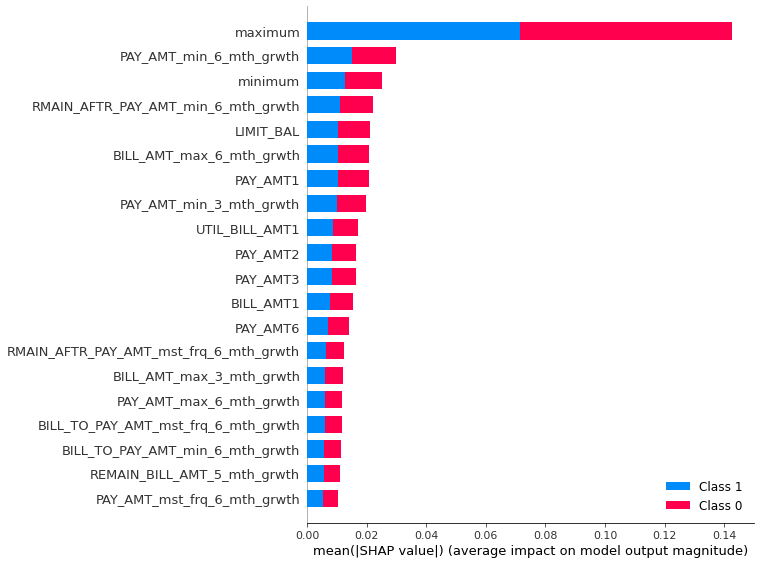

In [327]:
import shap
explainer = shap.TreeExplainer(new_rf)
shap_values = explainer.shap_values(x_tr_try)
shap.summary_plot(shap_values, x_tr_try)


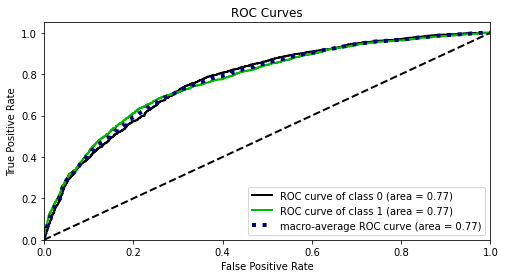

In [346]:
skplt.metrics.plot_roc(y_test.values,prediction, figsize=[8,4], plot_micro=False)
plt.show()

In [347]:
def cum_gains(data, act, pred, prob):
    data.sort_values(by=prob, ascending=False, inplace=True)
    subset = data[data[pred]==1]
    
    rows=[]
    for group in np.array_split(subset, 10):
        score =  accuracy_score(group[act].tolist(),
                                               group[pred].tolist(),
                                               normalize=False)
        try:
            auroc = roc_auc_score(group[act], group[prob])
        except:
            auroc=0.5
        tn, fp, fn, tp = confusion_matrix(group[act], group[pred]).ravel()
        ppv = tp / (tp + fp)

        sens = tp / (tp+fn)
        
        rows.append({'NumCases':len(group), 'NumCorrect': score, 'binauc':auroc, 'binppv':ppv, 'binsens':sens})
        
        
    lift = pd.DataFrame(rows)
    lift['RunningCorrect'] = lift['NumCorrect'].cumsum()
    lift['PercentCorrect'] = lift.apply(lambda x: (100 / lift['NumCorrect'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(lambda x: 100 if (100 / lift['NumCorrect'].sum()) * x > 100 else (100 / lift['NumCorrect'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrect'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(lambda x: (100/ lift['NumCorrect'].sum()) * x)
    
    lift['NormalizedPercentAvg'] = 1
    lift['NormalizedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']
    return lift

def plot_lift(data):
    plt.figure()
    plt.plot(data['NormalizedPercentAvg'], 'r-', label='Normalized response rate with no model')
    plt.plot(data['NormalizedPercentWithModel'], 'g-', marker='o', label='Normalized response rate with model')
    plt.legend()
    plt.show()
    
def plot_cumulative_gains(data):
    fig, ax = plt.subplots()
    fig.canvas.draw()
    handles = []
    handles.append(ax.plot(data['PercentCorrect'], 'r-', marker='o', label='Percent Correct Predictions'))
    handles.append(ax.plot(data['PercentCorrectBestCase'], 'g-', label='Best case for current model'))
    handles.append(ax.plot(data['PercentAvgCase'], 'b-', label='Average Case for current model'))
    ax.set_xlabel('Total Population (%)')
    ax.set_ylabel('Number of Respondent (%)')
    
    ax.set_xlim([0,9])
    ax.set_ylim([10,110])
#     print([str(item.get_text()) for item in ax.get_xticklabels()])
# #     print([item.get_text() for item in ax.get_xticklabels()])
#     labels = [str((label+1)*10) for label in [str(item.get_text()) for item in ax.get_xticklabels()]]
#     ax.set_xticklabels(labels)
    
    fig.legend(handles, labels=[h[0].get_label() for h in handles])
    fig.show()

You have mixed positional and keyword arguments, some input may be discarded.
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


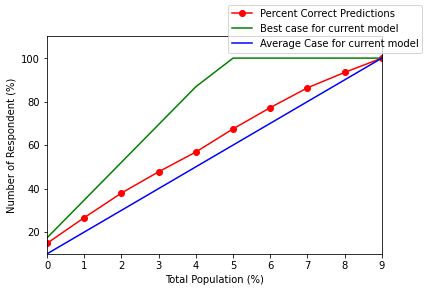

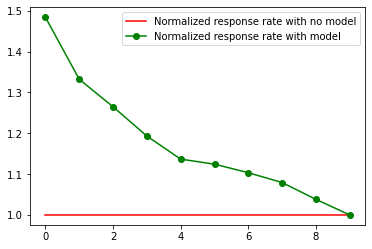

In [349]:


to_data = pd.DataFrame({'actual':y_test, 'pred':prediction[:,1]})
to_data.loc[to_data['pred']>0.5, 'result'] = 1
to_data.fillna(0, inplace=True)
cg = cum_gains(to_data, 'actual', 'result', 'pred')
cg.to_csv('CG.csv', index=False)
plot_cumulative_gains(cg)
plot_lift(cg)
result.to_csv('result.csv', index=False)

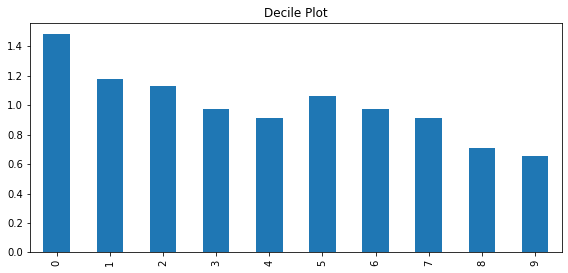

In [351]:
fig, ax = plt.subplots(figsize=[8,4])
cg['perc'] = cg['NumCorrect']/cg['AvgCase']
ax = cg['perc'].plot.bar()

ax.set_title('Decile Plot')
plt.tight_layout()
plt.subplots_adjust(top=0.88)

